In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import linalg
from sklearn.linear_model import LinearRegression
import calendar
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor as XGBR
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor as RFR

In [ ]:
#データの確認
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")
display(df_train.head(3))
#print(df_train.dtypes)
display(df_test.head(3))
#print(df_test.dtypes)

In [ ]:
#特徴量作成

#train
#年月日を含む日付に変更
D=pd.date_range("20180411", "20190326")
df_date = pd.DataFrame(D)
df_train["date"]=df_date
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month
df_train["day"] = df_train["date"].dt.day
#曜日
week = []
for i in range(len(df_train)):
    week.append(D[i].weekday())
df_week = pd.DataFrame(week)
df_train["week"]=df_week

#test
#年月日を含む日付に変更
D=pd.date_range("20190327", "20190416")
df_date = pd.DataFrame(D)
df_test["date"]=df_date
df_test["year"] = df_test["date"].dt.year
df_test["month"] = df_test["date"].dt.month
df_test["day"] = df_test["date"].dt.day
#曜日を反映
week = []
for i in range(len(df_test)):
    week.append(D[i].weekday())
df_week = pd.DataFrame(week)
df_test["week"]=df_week

# ice

In [ ]:
# 最高気温に対してプロット
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1,3,i+1)    
    plt.scatter(df_train["highest"],df_train["ice"+str(i+1)],label="ice"+str(i+1))
    plt.plot([min(df_test["highest"]),min(df_test["highest"])],[0,max(df_train["ice"+str(i+1)])],color = "red", label = "test_range")
    plt.plot([max(df_test["highest"]),max(df_test["highest"])],[0,max(df_train["ice"+str(i+1)])],color = "red")
    plt.xlabel("highest")
    plt.ylabel("ice"+str(i+1))
    plt.legend()

In [ ]:
# テストデータの範囲にフォーカス
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1,3,i+1)    
    plt.scatter(df_train["highest"][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"]))],
                 df_train["ice"+str(i+1)][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"]))],label="ice"+str(i+1))
    plt.xlabel("highest")
    plt.ylabel("ice"+str(i+1))
    plt.legend()

### テスト範囲にフォーカスすれば線形回帰でいけそう

In [ ]:
# 線形単回帰
def simple_regression(predictor_variable, x, y, test_x):
#    x = x.reshape(-1,1)
#    y = y.reshape(-1,1)
#    test_x = test_x.reshape(-1,1)
    
    model_lr = LinearRegression()
    model_lr.fit(x, y)
    pred_train = model_lr.predict(x)
    
    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    plt.scatter(x, y)
    plt.plot(x, model_lr.predict(x), linestyle="solid")
    
    #分位点検量線
    cmap = plt.cm.viridis(np.linspace(0., 1., 5))
 
    X = sm.add_constant(pred_train)
    model = QuantReg(y, X)
    
    taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    m = len(taus) 
    N = len(y)
    Y = np.zeros((m, N))
 
    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y[i] = y_hat
 
    plt.subplot(1,3,2)    
    plt.scatter(pred_train, y, color = "gray")
    for i in range(m):
        plt.plot([min(pred_train), max(pred_train)], [min(Y[i]), max(Y[i])], linewidth=2,
                  color=cmap[i], label=r"$\tau=$"+str(taus[i]))
    plt.xlabel("pred_train")
    plt.ylabel("y")
    plt.legend()
    
    #テストデータ予測
    pred_test = model_lr.predict(test_x)
    X = sm.add_constant(pred_test)

    Y2 = np.zeros((m, len(X)))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y2[i] = y_hat

    plt.subplot(1,3,3)    
    plt.scatter(x, y, color = "gray")

    for i in range(m):
        plt.scatter(test_x, Y2[i], color=cmap[i], label=r"$\tau=$"+str(taus[i]))

    plt.legend()
    
    #結果をテストデータに追加
    for i in range(m):
        df_test[predictor_variable+"_"+str(taus[i])]=Y2[i]
        
    return Y2,model_lr

In [ ]:
# ice1(外れ値除去)
x = df_train[["highest"]][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"])) & (df_train["ice1"] < 27)]
y = df_train[["ice1"]][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"])) & (df_train["ice1"] < 27)]
test_x = df_test[["highest"]]

ice1 = simple_regression("ice1", x, y, test_x)

In [ ]:
# ice2
x = df_train[["highest"]][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"]))]
y = df_train[["ice2"]][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"]))]
test_x = df_test[["highest"]]

ice2 = simple_regression("ice2", x, y, test_x)

In [ ]:
# ice3
x = df_train[["highest"]][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"]))]
y = df_train[["ice3"]][(df_train["highest"] >= min(df_test["highest"])) & (df_train["highest"] <= max(df_test["highest"]))]
test_x = df_test[["highest"]]

ice3 = simple_regression("ice3", x, y, test_x)

# oden

In [ ]:
#dateに対してプロット
plt.figure(figsize=(20, 8))
for i in range(4):
    plt.subplot(2,2,i+1)    
    plt.scatter(df_train["date"],df_train["oden"+str(i+1)],label="oden"+str(i+1))
    plt.xlabel("date")
    plt.ylabel("oden"+str(i+1))
#7,8,9月は販売していない

In [ ]:
#最低気温に対してプロット(販売していない時期は除外)
plt.figure(figsize=(20, 4))
for i in range(4):
    plt.subplot(1,4,i+1)    
    plt.scatter(df_train["lowest"][(df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)],df_train["oden"+str(i+1)][(df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)],label="oden"+str(i+1))
    plt.scatter(df_train["lowest"][(df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)],2*df_train["oden"+str(i+1)][(df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)],label="oden"+str(i+1)+"x2", alpha=0.1)
    plt.plot([min(df_test["lowest"]),min(df_test["lowest"])],[0,max(df_train["oden"+str(i+1)])],color = "red")
    plt.plot([max(df_test["lowest"]),max(df_test["lowest"])],[0,max(df_train["oden"+str(i+1)])],color = "red")
    plt.xlabel("lowest")
    plt.ylabel("oden"+str(i+1))
    plt.ylim(0,max(df_train["oden"+str(i+1)])+10)
    plt.legend()

In [ ]:
# テストデータの範囲にフォーカス
plt.figure(figsize=(20, 4))
for i in range(4):
    plt.subplot(1,4,i+1)    
    plt.scatter(df_train["lowest"][(df_train["lowest"] >= min(df_test["lowest"])) & (df_train["lowest"] <= max(df_test["lowest"]))],
                 df_train["oden"+str(i+1)][(df_train["lowest"] >= min(df_test["lowest"])) & (df_train["lowest"] <= max(df_test["lowest"]))],label="ice"+str(i+1))
    plt.scatter(df_train["lowest"][(df_train["lowest"] >= min(df_test["lowest"])) & (df_train["lowest"] <= max(df_test["lowest"]))],
                 2*df_train["oden"+str(i+1)][(df_train["lowest"] >= min(df_test["lowest"])) & (df_train["lowest"] <= max(df_test["lowest"]))],label="ice"+str(i+1)+"x2", alpha=0.1)
    plt.xlabel("lowest")
    plt.ylabel("oden"+str(i+1))
    plt.legend()

### ～10℃、10～20℃、20℃～で傾きが違うが、線形回帰で行けそう
### 上側にばらつくときがある、その大きさは上限の2倍

In [ ]:
# oden1
x_10 = df_train[["lowest"]][df_train["lowest"] <= 9.5]
y_10 = df_train[["oden1"]][df_train["lowest"] <= 9.5]
#plt.scatter(x_10, y_10)
x_20 = df_train[["lowest"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 14.5) & (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
y_20 = df_train[["oden1"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 14.5) & (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
#plt.scatter(x_20, y_20)

In [ ]:
test_x = df_test[["lowest"]]

oden1_10 = simple_regression("oden1", x_10, y_10, test_x) #10℃以下のモデル
oden1_20 = simple_regression("oden1", x_20, y_20, test_x) #10～20℃のモデル

In [ ]:
#testデータ予測
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["lowest"][i] < 10:
            df_test["oden1_" + list[j]][i] = oden1_10[0][j][i]
        elif df_test["lowest"][i] >= 10:
            df_test["oden1_" + list[j]][i] = oden1_20[0][j][i]

df_test["oden1_0.99"] = 2*df_test["oden1_0.99"]

plt.scatter(df_test["lowest"],df_test["oden1_0.01"])
plt.scatter(df_test["lowest"],df_test["oden1_0.1"])
plt.scatter(df_test["lowest"],df_test["oden1_0.5"])
plt.scatter(df_test["lowest"],df_test["oden1_0.9"])
plt.scatter(df_test["lowest"],df_test["oden1_0.99"])

In [ ]:
# oden2
x_10 = df_train[["lowest"]][(df_train["lowest"] <= 10) & (df_train["oden2"] <= 150)]
y_10 = df_train[["oden2"]][(df_train["lowest"] <= 10) & (df_train["oden2"] <= 150)]
#plt.scatter(x_10, y_10)
x_20 = df_train[["lowest"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 15) & (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
y_20 = df_train[["oden2"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 15) & (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
#plt.scatter(x_20, y_20)

In [ ]:
test_x = df_test[["lowest"]]

oden2_10 = simple_regression("oden2", x_10, y_10, test_x)
oden2_20 = simple_regression("oden2", x_20, y_20, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["lowest"][i] < 10:
            df_test["oden2_" + list[j]][i] = oden2_10[0][j][i]
        elif df_test["lowest"][i] >= 10:
            df_test["oden2_" + list[j]][i] = oden2_20[0][j][i]

df_test["oden2_0.99"] = 2*df_test["oden2_0.99"]
            
plt.scatter(df_test["lowest"],df_test["oden2_0.01"])
plt.scatter(df_test["lowest"],df_test["oden2_0.1"])
plt.scatter(df_test["lowest"],df_test["oden2_0.5"])
plt.scatter(df_test["lowest"],df_test["oden2_0.9"])
plt.scatter(df_test["lowest"],df_test["oden2_0.99"])

In [ ]:
# oden3
x_10 = df_train[["lowest"]][(df_train["lowest"] <= 8) & (df_train["oden3"] <= 250)]
y_10 = df_train[["oden3"]][(df_train["lowest"] <= 8) & (df_train["oden3"] <= 250)]
#plt.scatter(x_10, y_10)
x_20 = df_train[["lowest"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 15) & (df_train["oden3"] <= 90)& (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
y_20 = df_train[["oden3"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 15) & (df_train["oden3"] <= 90)& (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
#plt.scatter(x_20, y_20)

In [ ]:
test_x = df_test[["lowest"]]

oden3_10 = simple_regression("oden3", x_10, y_10, test_x)
oden3_20 = simple_regression("oden3", x_20, y_20, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["lowest"][i] < 10:
            df_test["oden3_" + list[j]][i] = oden3_10[0][j][i]
        elif df_test["lowest"][i] >= 10:
            df_test["oden3_" + list[j]][i] = oden3_20[0][j][i]

df_test["oden3_0.99"] = 2*df_test["oden3_0.99"]

plt.scatter(df_test["lowest"],df_test["oden3_0.01"])
plt.scatter(df_test["lowest"],df_test["oden3_0.1"])
plt.scatter(df_test["lowest"],df_test["oden3_0.5"])
plt.scatter(df_test["lowest"],df_test["oden3_0.9"])
plt.scatter(df_test["lowest"],df_test["oden3_0.99"])

In [ ]:
# oden4
x_10 = df_train[["lowest"]][(df_train["lowest"] <= 10) & (df_train["oden4"] <= 150)]
y_10 = df_train[["oden4"]][(df_train["lowest"] <= 10) & (df_train["oden4"] <= 150)]
#plt.scatter(x_10, y_10)
x_20 = df_train[["lowest"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 20) & (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
y_20 = df_train[["oden4"]][(df_train["lowest"] >= 10) & (df_train["lowest"] <= 20) & (df_train["month"] != 7)&(df_train["month"] != 8)&(df_train["month"] != 9)]
#plt.scatter(x_20, y_20)

In [ ]:
test_x = df_test[["lowest"]]

oden4_10 = simple_regression("oden4", x_10, y_10, test_x)
oden4_20 = simple_regression("oden4", x_20, y_20, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["lowest"][i] < 10:
            df_test["oden4_" + list[j]][i] = oden4_10[0][j][i]
        elif df_test["lowest"][i] >= 10:
            df_test["oden4_" + list[j]][i] = oden4_20[0][j][i]

df_test["oden4_0.99"] = 2*df_test["oden4_0.99"]

plt.scatter(df_test["lowest"],df_test["oden4_0.01"])
plt.scatter(df_test["lowest"],df_test["oden4_0.1"])
plt.scatter(df_test["lowest"],df_test["oden4_0.5"])
plt.scatter(df_test["lowest"],df_test["oden4_0.9"])
plt.scatter(df_test["lowest"],df_test["oden4_0.99"])

# hot

In [ ]:
# 最低気温に対してプロット
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1,3,i+1)    
    plt.scatter(df_train["lowest"],df_train["hot"+str(i+1)],label="hot"+str(i+1))
    plt.plot([min(df_test["lowest"]),min(df_test["lowest"])],[0,max(df_train["hot"+str(i+1)])],color = "red")
    plt.plot([max(df_test["lowest"]),max(df_test["lowest"])],[0,max(df_train["hot"+str(i+1)])],color = "red")
    plt.xlabel("lowest")
    plt.ylabel("hot"+str(i+1))

In [ ]:
# 週別でみる + 15℃までの範囲にフォーカス
plt.figure(figsize=(15, 4))
for j in range(7):
    for i in range(3):
        plt.subplot(1,3,i+1)    
        plt.scatter(df_train["lowest"][(df_train["week"] == j) & (df_train["lowest"] <= 15)],df_train["hot"+str(i+1)][(df_train["week"] == j) & (df_train["lowest"] <= 15)],label="week="+str(j))
        plt.plot([min(df_test["lowest"]),min(df_test["lowest"])],[0,max(df_train["hot"+str(i+1)])],color = "red")
        plt.plot([max(df_test["lowest"]),max(df_test["lowest"])],[0,max(df_train["hot"+str(i+1)])],color = "red")
        plt.xlabel("lowest")
        plt.ylabel("hot"+str(i+1))
        plt.ylim(min(df_train["hot" + str(i+1)])-10, max(df_train["hot" + str(i+1)])+10)
        plt.legend()

### 15℃以上、以下で傾きが違うが、線形回帰で行けそう
### 週で違う(分けないほうがLB高い)

In [ ]:
# 線形重回帰
def multiple_regression(predictor_variable, x, y, test_x):
    
    model_lr = LinearRegression()
    model_lr.fit(x, y)
    pred_train = model_lr.predict(x)
    
    plt.figure(figsize=(5, 4))
#    plt.subplot(1,3,1)
#    plt.scatter(x, y)
#    plt.plot(x, model_lr.predict(x), linestyle="solid")
    
    #分位点検量線
    cmap = plt.cm.viridis(np.linspace(0., 1., 5))
 
    X = sm.add_constant(pred_train)
    model = QuantReg(y, X)
    
    taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    m = len(taus) 
    N = len(y)
    Y = np.zeros((m, N))
 
    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y[i] = y_hat
 
    #plt.subplot(1,3,2)    
    plt.scatter(pred_train, y, color = "gray")
    for i in range(m):
        plt.plot([min(pred_train), max(pred_train)], [min(Y[i]), max(Y[i])], linewidth=2,
                  color=cmap[i], label=r"$\tau=$"+str(taus[i]))
    plt.xlabel("pred_train")
    plt.ylabel("y")
    plt.legend()
    
    #テストデータ予測
    pred_test = model_lr.predict(test_x)
    X = sm.add_constant(pred_test)

    Y2 = np.zeros((m, len(X)))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y2[i] = y_hat
    
    #結果をテストデータに追加
    for i in range(m):
        df_test[predictor_variable+"_"+str(taus[i])]=Y2[i]
        
    return Y2, model_lr

In [ ]:
##week cat   週は使用しないほうが良かったので削除
#for w in range(7):
#    df_train["week_cat_"+str(w)] = 0
#
#for i in range(len(df_train)):
#    for w in range(7):
#        if df_train["week"][i] == w:
#            df_train["week_cat_" + str(w)][i] = 1
#            
##week cat
#for w in range(7):
#    df_test["week_cat_"+str(w)] = 0
#
#for i in range(len(df_test)):
#    for w in range(7):
#        if df_test["week"][i] == w:
#            df_test["week_cat_" + str(w)][i] = 1

In [ ]:
# hot1
#x_u15 = df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]][(df_train["lowest"] <= 15)]
x_u15 = df_train[["lowest"]][(df_train["lowest"] <= 15)]
y_u15 = df_train[["hot1"]][(df_train["lowest"] <= 15)]
#plt.scatter(x_u15["lowest"], y_u15)
#x_o15 = df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]][(df_train["lowest"] >= 15)]
x_o15 = df_train[["lowest"]][(df_train["lowest"] >= 15)]
y_o15 = df_train[["hot1"]][(df_train["lowest"] >= 15)]
#plt.scatter(x_o15["lowest"], y_o15)

In [ ]:
#test_x = df_test[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]]
test_x = df_test[["lowest"]]

hot1_u15 = multiple_regression("hot1", x_u15, y_u15, test_x)
hot1_o15 = multiple_regression("hot1", x_o15, y_o15, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        df_test["hot1_" + list[j]][i] = hot1_u15[0][j][i]

plt.scatter(df_test["lowest"],df_test["hot1_0.01"])
plt.scatter(df_test["lowest"],df_test["hot1_0.1"])
plt.scatter(df_test["lowest"],df_test["hot1_0.5"])
plt.scatter(df_test["lowest"],df_test["hot1_0.9"])
plt.scatter(df_test["lowest"],df_test["hot1_0.99"])

In [ ]:
#trainデータの予測
df_train["pred_hot1"] = 0
for i in range(len(df_train)):
    if df_train["lowest"][i] <= 15:
#        df_train["pred_hot1"][i] = hot1_u15[1].predict(df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]])[i]
        df_train["pred_hot1"][i] = hot1_u15[1].predict(df_train[["lowest"]])[i]
    else:
#        df_train["pred_hot1"][i] = hot1_o15[1].predict(df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]])[i]
        df_train["pred_hot1"][i] = hot1_o15[1].predict(df_train[["lowest"]])[i]
#plt.scatter(df_train["pred_hot1"], df_train["hot1"])

In [ ]:
# hot2
#x_u15 = df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]][(df_train["lowest"] <= 15)]
x_u15 = df_train[["lowest"]][(df_train["lowest"] <= 15)]
y_u15 = df_train[["hot2"]][(df_train["lowest"] <= 15)]
#plt.scatter(x_u15["lowest"], y_u15)
#x_o15 = df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]][(df_train["lowest"] >= 15)]
x_o15 = df_train[["lowest"]][(df_train["lowest"] >= 15)]
y_o15 = df_train[["hot2"]][(df_train["lowest"] >= 15)]
#plt.scatter(x_o15["lowest"], y_o15)

In [ ]:
#test_x = df_test[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]]
test_x = df_test[["lowest"]]

hot2_u15 = multiple_regression("hot2", x_u15, y_u15, test_x)
hot2_o15 = multiple_regression("hot2", x_o15, y_o15, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        df_test["hot2_" + list[j]][i] = hot2_u15[0][j][i]

plt.scatter(df_test["lowest"],df_test["hot2_0.01"])
plt.scatter(df_test["lowest"],df_test["hot2_0.1"])
plt.scatter(df_test["lowest"],df_test["hot2_0.5"])
plt.scatter(df_test["lowest"],df_test["hot2_0.9"])
plt.scatter(df_test["lowest"],df_test["hot2_0.99"])

In [ ]:
#trainデータの予測
df_train["pred_hot2"] = 0
for i in range(len(df_train)):
    if df_train["lowest"][i] <= 15:
#        df_train["pred_hot2"][i] = hot2_u15[1].predict(df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]])[i]
        df_train["pred_hot2"][i] = hot2_u15[1].predict(df_train[["lowest"]])[i]
    else:
#        df_train["pred_hot2"][i] = hot2_o15[1].predict(df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]])[i]
        df_train["pred_hot2"][i] = hot2_o15[1].predict(df_train[["lowest"]])[i]
#plt.scatter(df_train["pred_hot2"], df_train["hot2"])

In [ ]:
# hot3
#x_u15 = df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]][(df_train["lowest"] <= 15)]
x_u15 = df_train[["lowest"]][(df_train["lowest"] <= 15)]
y_u15 = df_train[["hot3"]][(df_train["lowest"] <= 15)]
#plt.scatter(x_u15["lowest"], y_u15)
#x_o15 = df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]][(df_train["lowest"] >= 15)]
x_o15 = df_train[["lowest"]][(df_train["lowest"] >= 15)]
y_o15 = df_train[["hot3"]][(df_train["lowest"] >= 15)]
#plt.scatter(x_o15["lowest"], y_o15)

In [ ]:
#test_x = df_test[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]]
test_x = df_test[["lowest"]]

hot3_u15 = multiple_regression("hot3", x_u15, y_u15, test_x)
hot3_o15 = multiple_regression("hot3", x_o15, y_o15, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        df_test["hot3_" + list[j]][i] = hot3_u15[0][j][i]

plt.scatter(df_test["lowest"],df_test["hot3_0.01"])
plt.scatter(df_test["lowest"],df_test["hot3_0.1"])
plt.scatter(df_test["lowest"],df_test["hot3_0.5"])
plt.scatter(df_test["lowest"],df_test["hot3_0.9"])
plt.scatter(df_test["lowest"],df_test["hot3_0.99"])

In [ ]:
#trainデータの予測
df_train["pred_hot3"] = 0
for i in range(len(df_train)):
    if df_train["lowest"][i] <= 15:
#        df_train["pred_hot3"][i] = hot3_u15[1].predict(df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]])[i]
        df_train["pred_hot3"][i] = hot3_u15[1].predict(df_train[["lowest"]])[i]
    else:
#        df_train["pred_hot3"][i] = hot3_o15[1].predict(df_train[["lowest","rain","week_cat_0","week_cat_1","week_cat_2","week_cat_3","week_cat_4","week_cat_5","week_cat_6"]])[i]
        df_train["pred_hot3"][i] = hot3_o15[1].predict(df_train[["lowest"]])[i]
#plt.scatter(df_train["pred_hot3"], df_train["hot3"])

# dessert

In [ ]:
# 日に対して週別にプロット
plt.figure(figsize=(15, 12))
for j in range(7):
    for i in range(5):
        plt.subplot(3,2,i+1)    
        plt.scatter(df_train["day"][(df_train["week"] == j)],df_train["dessert"+str(i+1)][(df_train["week"] == j)],label="week="+str(j))
        plt.xlabel("day")
        plt.ylabel("dessert"+str(i+1))
plt.legend()

### 日と週(0,1,3,4,5 or 2,6)で決まっている

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]
for d in range(5):
    for m in range(5):
        df_test["dessert"+str(d+1)+"_"+list[m]] = 0

for i in range(len(df_test)):
    if ((df_test["week"][i] == 2) | (df_test["week"][i] == 6)):
        for d in range(5):
            df_test["dessert"+str(d+1)+"_0.5"][i] = np.average(df_train["dessert"+str(d+1)][(df_train["day"] == df_test["day"][i]) & ((df_train["week"] == 2)|(df_train["week"] == 6))]) 
            df_test["dessert"+str(d+1)+"_0.01"][i] = np.min(df_train["dessert"+str(d+1)][(df_train["day"] == df_test["day"][i]) & ((df_train["week"] == 2)|(df_train["week"] == 6))]) 
            df_test["dessert"+str(d+1)+"_0.99"][i] = np.max(df_train["dessert"+str(d+1)][(df_train["day"] == df_test["day"][i]) & ((df_train["week"] == 2)|(df_train["week"] == 6))]) 
            df_test["dessert"+str(d+1)+"_0.1"][i] = (df_test["dessert"+str(d+1)+"_0.5"][i] +4*df_test["dessert"+str(d+1)+"_0.01"][i])/5
            df_test["dessert"+str(d+1)+"_0.9"][i] = (df_test["dessert"+str(d+1)+"_0.5"][i] +4*df_test["dessert"+str(d+1)+"_0.99"][i])/5
    else:
        for d in range(5):
            df_test["dessert"+str(d+1)+"_0.5"][i] = np.average(df_train["dessert"+str(d+1)][(df_train["day"] == df_test["day"][i]) & ((df_train["week"] == 0)|(df_train["week"] == 1)|(df_train["week"] == 3)|(df_train["week"] == 4)|(df_train["week"] == 5))]) 
            df_test["dessert"+str(d+1)+"_0.01"][i] = np.min(df_train["dessert"+str(d+1)][(df_train["day"] == df_test["day"][i]) & ((df_train["week"] == 0)|(df_train["week"] == 1)|(df_train["week"] == 3)|(df_train["week"] == 4)|(df_train["week"] == 5))]) 
            df_test["dessert"+str(d+1)+"_0.99"][i] = np.max(df_train["dessert"+str(d+1)][(df_train["day"] == df_test["day"][i]) & ((df_train["week"] == 0)|(df_train["week"] == 1)|(df_train["week"] == 3)|(df_train["week"] == 4)|(df_train["week"] == 5))]) 
            df_test["dessert"+str(d+1)+"_0.1"][i] = (df_test["dessert"+str(d+1)+"_0.5"][i] +4*df_test["dessert"+str(d+1)+"_0.01"][i])/5
            df_test["dessert"+str(d+1)+"_0.9"][i] = (df_test["dessert"+str(d+1)+"_0.5"][i] +4*df_test["dessert"+str(d+1)+"_0.99"][i])/5
            
for d in range(5):
    df_train["pred_dessert"+str(d+1)] = 0

for i in range(len(df_train)):
    if ((df_train["week"][i] == 2) | (df_train["week"][i] == 6)):
        for d in range(5):
            df_train["pred_dessert"+str(d+1)][i] = np.average(df_train["dessert"+str(d+1)][(df_train["day"] == df_train["day"][i]) & ((df_train["week"] == 2)|(df_train["week"] == 6))]) 
    else:
        for d in range(5):
            df_train["pred_dessert"+str(d+1)][i] = np.average(df_train["dessert"+str(d+1)][(df_train["day"] == df_train["day"][i]) & ((df_train["week"] == 0)|(df_train["week"] == 1)|(df_train["week"] == 3)|(df_train["week"] == 4)|(df_train["week"] == 5))]) 

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.01"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.1"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.5"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.9"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.99"])
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))

In [ ]:
#trainデータの予測結果
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_train["day"],df_train["pred_dessert"+str(i+1)])
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))

# drink

In [ ]:
# 最高気温に対してプロット
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["highest"],df_train["drink"+str(i+1)],label="ice"+str(i+1))
    plt.plot([min(df_test["highest"]),min(df_test["highest"])],[0,max(df_train["drink"+str(i+1)])],color = "red")
    plt.plot([max(df_test["highest"]),max(df_test["highest"])],[0,max(df_train["drink"+str(i+1)])],color = "red")
    plt.xlabel("highest")
    plt.ylabel("drink"+str(i+1))

In [ ]:
#雨
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["highest"][(df_train["rain"] > 50)],df_train["drink"+str(i+1)][(df_train["rain"] > 50)],label = "rain > 50")
    plt.scatter(df_train["highest"][(df_train["rain"] <= 50)],df_train["drink"+str(i+1)][(df_train["rain"] <= 50)],label = "50 > rain > 40")
    plt.scatter(df_train["highest"][(df_train["rain"] <= 40)],df_train["drink"+str(i+1)][(df_train["rain"] <= 40)],label = "40 > rain > 30")
    plt.scatter(df_train["highest"][(df_train["rain"] <= 30)],df_train["drink"+str(i+1)][(df_train["rain"] <= 30)],label = "30 > rain > 20")
    plt.scatter(df_train["highest"][(df_train["rain"] <= 20)],df_train["drink"+str(i+1)][(df_train["rain"] <= 20)],label = "20 > rain > 10")
    plt.scatter(df_train["highest"][(df_train["rain"] <= 10)],df_train["drink"+str(i+1)][(df_train["rain"] <= 10)],label = "10 > rain > 5")
    plt.scatter(df_train["highest"][(df_train["rain"] <= 5)],df_train["drink"+str(i+1)][(df_train["rain"] <= 5)],label = "5 > rain > 0")
    plt.scatter(df_train["highest"][(df_train["rain"] == 0)],df_train["drink"+str(i+1)][(df_train["rain"] == 0)],label = "rain = 0")
    plt.plot([min(df_test["highest"]),min(df_test["highest"])],[0,max(df_train["drink"+str(i+1)])],color = "red")
    plt.plot([max(df_test["highest"]),max(df_test["highest"])],[0,max(df_train["drink"+str(i+1)])],color = "red")
    plt.xlabel("highest")
    plt.ylabel("drink"+str(i+1))
    plt.legend()

In [ ]:
#週
plt.figure(figsize=(15, 8))
for j in range(7):
    for i in range(6):
        plt.subplot(2,3,i+1)    
        plt.scatter(df_train["highest"][(df_train["week"] == j)],df_train["drink"+str(i+1)][(df_train["week"] == j)],label = "week="+str(j) )
        plt.plot([min(df_test["highest"]),min(df_test["highest"])],[0,max(df_train["drink"+str(i+1)])],color = "red")
        plt.plot([max(df_test["highest"]),max(df_test["highest"])],[0,max(df_train["drink"+str(i+1)])],color = "red")
        plt.xlabel("highest")
        plt.ylabel("drink"+str(i+1))
        plt.legend()

### 最高気温と降水量と週で決まる
### drink1～4は15℃以下は定数、15℃以上は右肩上がり直線
### drink5,6は10℃以下は右肩下がり直線、10℃以上は定数
### drink1～3は雨降ると売り上げ下がる
### drink5,6は雨降ると売り上げ上がる
### drink2,3はweek=4でばらつき増える

In [ ]:
for i in range(6):
    df_train["pred_drink"+str(i+1)] = 0

In [ ]:
# drink1
df_train["rain**2"] =df_train["rain"]**2

x_u15 = df_train[["rain", "rain**2"]][(df_train["highest"] <= 15)]
y_u15 = df_train[["drink1"]][(df_train["highest"] <= 15)]
#plt.scatter(x_u15["rain"], y_u15)

x_o15 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] >= 15)]
y_o15 = df_train[["drink1"]][(df_train["highest"] >= 15)]
#plt.scatter(x_o15["highest"], y_o15)

In [ ]:
#15℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink1_o15 = multiple_regression("drink1", x_o15, y_o15, test_x)

In [ ]:
#15℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["rain", "rain**2"]]

drink1_u15 = multiple_regression("drink1", x_u15, y_u15, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["highest"][i] >= 15:
            df_test["drink1_" + list[j]][i] = drink1_o15[0][j][i]
        else:
            df_test["drink1_" + list[j]][i] = drink1_u15[0][j][i]
            #下限値処理
            if df_test["drink1_" + list[j]][i] <= np.min(df_train["drink1"]):
                df_test["drink1_" + list[j]][i] = np.min(df_train["drink1"])

plt.scatter(df_test["highest"],df_test["drink1_0.01"])
plt.scatter(df_test["highest"],df_test["drink1_0.1"])
plt.scatter(df_test["highest"],df_test["drink1_0.5"])
plt.scatter(df_test["highest"],df_test["drink1_0.9"])
plt.scatter(df_test["highest"],df_test["drink1_0.99"])

In [ ]:
#trainデータの予測
for i in range(len(df_train)):
    if df_train["highest"][i] >= 15:
        df_train["pred_drink1"][i] = drink1_o15[1].predict(df_train[["highest","rain", "rain**2"]])[i]
    else:
        df_train["pred_drink1"][i] = drink1_u15[1].predict(df_train[["rain", "rain**2"]])[i]
        
#plt.scatter(df_train["pred_drink1"], df_train["drink1"])

In [ ]:
# drink2(week≠4)
df_train["rain**2"] =df_train["rain"]**2

x_u15 = df_train[["rain","rain**2"]][(df_train["highest"] <= 15) & (df_train["week"] != 4)]
y_u15 = df_train[["drink2"]][(df_train["highest"] <= 15) & (df_train["week"] != 4)]
#plt.scatter(x_u15["rain"], y_u15)

x_o15 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] >= 15) & (df_train["week"] != 4)]
y_o15 = df_train[["drink2"]][(df_train["highest"] >= 15) & (df_train["week"] != 4)]
#plt.scatter(x_o15["highest"], y_o15)

In [ ]:
#15℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink2_o15 = multiple_regression("drink2", x_o15, y_o15, test_x)

In [ ]:
#15℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["rain", "rain**2"]]

drink2_u15 = multiple_regression("drink2", x_u15, y_u15, test_x)

In [ ]:
# drink2(week=4)
df_train["rain**2"] =df_train["rain"]**2

x_u15_w4 = df_train[["rain","rain**2"]][(df_train["highest"] <= 15)]
y_u15_w4 = df_train[["drink2"]][(df_train["highest"] <= 15)]
#plt.scatter(x_u15_w4["rain"], y_u15_w4)

x_o15_w4 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] >= 15)]
y_o15_w4 = df_train[["drink2"]][(df_train["highest"] >= 15)]
#plt.scatter(x_o15_w4["highest"], y_o15_w4)

In [ ]:
#15℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink2_o15_w4 = multiple_regression("drink2", x_o15_w4, y_o15_w4, test_x)

In [ ]:
#15℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["rain", "rain**2"]]

drink2_u15_w4 = multiple_regression("drink2", x_u15_w4, y_u15_w4, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["week"][i] == 4:
            if df_test["highest"][i] >=15:
                df_test["drink2_" + list[j]][i] = drink2_o15_w4[0][j][i]                
            else:
                df_test["drink2_" + list[j]][i] = drink2_u15_w4[0][j][i]
                #下限値処理
                if df_test["drink2_" + list[j]][i] <= np.min(df_train["drink2"]):
                    df_test["drink2_" + list[j]][i] = np.min(df_train["drink2"])
        else:
            if df_test["highest"][i] >=15:
                df_test["drink2_" + list[j]][i] = drink2_o15[0][j][i]                
            else:
                df_test["drink2_" + list[j]][i] = drink2_u15[0][j][i]
                #下限値処理
                if df_test["drink2_" + list[j]][i] <= np.min(df_train["drink2"]):
                    df_test["drink2_" + list[j]][i] = np.min(df_train["drink2"])

plt.scatter(df_test["highest"],df_test["drink2_0.01"])
plt.scatter(df_test["highest"],df_test["drink2_0.1"])
plt.scatter(df_test["highest"],df_test["drink2_0.5"])
plt.scatter(df_test["highest"],df_test["drink2_0.9"])
plt.scatter(df_test["highest"],df_test["drink2_0.99"])

In [ ]:
#trainデータの予測
for i in range(len(df_train)):
    if df_train["week"][i] == 4:
        if df_train["highest"][i] >= 15:
            df_train["pred_drink2"][i] = drink2_o15_w4[1].predict(df_train[["highest","rain", "rain**2"]])[i]
        else:
            df_train["pred_drink2"][i] = drink2_u15_w4[1].predict(df_train[["rain", "rain**2"]])[i]
    else:
        if df_train["highest"][i] >= 15:
            df_train["pred_drink2"][i] = drink2_o15[1].predict(df_train[["highest","rain", "rain**2"]])[i]
        else:
            df_train["pred_drink2"][i] = drink2_u15[1].predict(df_train[["rain", "rain**2"]])[i]
            
#plt.scatter(df_train["pred_drink2"], df_train["drink2"])

In [ ]:
# drink3(week≠4)
df_train["rain**2"] =df_train["rain"]**2

x_u15 = df_train[["rain","rain**2"]][(df_train["highest"] <= 15) & (df_train["week"] != 4)]
y_u15 = df_train[["drink3"]][(df_train["highest"] <= 15) & (df_train["week"] != 4)]
#plt.scatter(x_u15["rain"], y_u15)

x_o15 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] >= 15) & (df_train["week"] != 4)]
y_o15 = df_train[["drink3"]][(df_train["highest"] >= 15) & (df_train["week"] != 4)]
#plt.scatter(x_o15["highest"], y_o15)

In [ ]:
#15℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink3_o15 = multiple_regression("drink3", x_o15, y_o15, test_x)

In [ ]:
#15℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["rain", "rain**2"]]

drink3_u15 = multiple_regression("drink3", x_u15, y_u15, test_x)

In [ ]:
# drink3(week=4)
df_train["rain**2"] =df_train["rain"]**2

x_u15_w4 = df_train[["rain","rain**2"]][(df_train["highest"] <= 15)]
y_u15_w4 = df_train[["drink3"]][(df_train["highest"] <= 15)]
#plt.scatter(x_u15_w4["rain"], y_u15_w4)

x_o15_w4 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] >= 15)]
y_o15_w4 = df_train[["drink3"]][(df_train["highest"] >= 15)]
#plt.scatter(x_o15_w4["highest"], y_o15_w4)

In [ ]:
#15℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink3_o15_w4 = multiple_regression("drink3", x_o15_w4, y_o15_w4, test_x)

In [ ]:
#15℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["rain", "rain**2"]]

drink3_u15_w4 = multiple_regression("drink3", x_u15_w4, y_u15_w4, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["week"][i] == 4:
            if df_test["highest"][i] >=15:
                df_test["drink3_" + list[j]][i] = drink3_o15_w4[0][j][i]                
            else:
                df_test["drink3_" + list[j]][i] = drink3_u15_w4[0][j][i]
                #下限値処理
                if df_test["drink3_" + list[j]][i] <= np.min(df_train["drink3"]):
                    df_test["drink3_" + list[j]][i] = np.min(df_train["drink3"])
        else:
            if df_test["highest"][i] >=15:
                df_test["drink3_" + list[j]][i] = drink3_o15[0][j][i]                
            else:
                df_test["drink3_" + list[j]][i] = drink3_u15[0][j][i]
                #下限値処理
                if df_test["drink3_" + list[j]][i] <= np.min(df_train["drink3"]):
                    df_test["drink3_" + list[j]][i] = np.min(df_train["drink3"])

plt.scatter(df_test["highest"],df_test["drink3_0.01"])
plt.scatter(df_test["highest"],df_test["drink3_0.1"])
plt.scatter(df_test["highest"],df_test["drink3_0.5"])
plt.scatter(df_test["highest"],df_test["drink3_0.9"])
plt.scatter(df_test["highest"],df_test["drink3_0.99"])

In [ ]:
#trainデータの予測
for i in range(len(df_train)):
    if df_train["week"][i] == 4:
        if df_train["highest"][i] >= 15:
            df_train["pred_drink3"][i] = drink3_o15_w4[1].predict(df_train[["highest","rain", "rain**2"]])[i]
        else:
            df_train["pred_drink3"][i] = drink3_u15_w4[1].predict(df_train[["rain", "rain**2"]])[i]
    else:
        if df_train["highest"][i] >= 15:
            df_train["pred_drink3"][i] = drink3_o15[1].predict(df_train[["highest","rain", "rain**2"]])[i]
        else:
            df_train["pred_drink3"][i] = drink3_u15[1].predict(df_train[["rain", "rain**2"]])[i]
            
#plt.scatter(df_train["pred_drink3"], df_train["drink3"])

In [ ]:
# drink4
df_train["rain**2"] =df_train["rain"]**2

x_u15 = df_train[["rain", "rain**2"]][(df_train["highest"] <= 15)]
y_u15 = df_train[["drink4"]][(df_train["highest"] <= 15)]
#plt.scatter(x_u15["rain"], y_u15)

x_o15 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] >= 15)]
y_o15 = df_train[["drink4"]][(df_train["highest"] >= 15)]
#plt.scatter(x_o15["highest"], y_o15)

In [ ]:
#15℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink4_o15 = multiple_regression("drink4", x_o15, y_o15, test_x)

In [ ]:
#15℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["rain", "rain**2"]]

drink4_u15 = multiple_regression("drink4", x_u15, y_u15, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["highest"][i] >= 15:
            df_test["drink4_" + list[j]][i] = drink4_o15[0][j][i]
        else:
            df_test["drink4_" + list[j]][i] = drink4_u15[0][j][i]
            #下限値処理
            if df_test["drink4_" + list[j]][i] <= np.min(df_train["drink4"]):
                df_test["drink4_" + list[j]][i] = np.min(df_train["drink4"])

plt.scatter(df_test["highest"],df_test["drink4_0.01"])
plt.scatter(df_test["highest"],df_test["drink4_0.1"])
plt.scatter(df_test["highest"],df_test["drink4_0.5"])
plt.scatter(df_test["highest"],df_test["drink4_0.9"])
plt.scatter(df_test["highest"],df_test["drink4_0.99"])

In [ ]:
#trainデータの予測
for i in range(len(df_train)):
    if df_train["highest"][i] >= 15:
        df_train["pred_drink4"][i] = drink4_o15[1].predict(df_train[["highest","rain", "rain**2"]])[i]
    else:
        df_train["pred_drink4"][i] = drink4_u15[1].predict(df_train[["rain", "rain**2"]])[i]
        
#plt.scatter(df_train["pred_drink4"], df_train["drink4"])

In [ ]:
# drink5
df_train["rain**2"] =df_train["rain"]**2

x_o10 = df_train[["rain", "rain**2"]][(df_train["highest"] >= 10)]
y_o10 = df_train[["drink5"]][(df_train["highest"] >= 10)]
#plt.scatter(x_o10["rain"], y_o10)

x_u10 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] <= 10)]
y_u10 = df_train[["drink5"]][(df_train["highest"] <= 10)]
#plt.scatter(x_u10["highest"], y_u10)

In [ ]:
#10℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink5_u10 = multiple_regression("drink5", x_u10, y_u10, test_x)

In [ ]:
#10℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["rain", "rain**2"]]

drink5_o10 = multiple_regression("drink5", x_o10, y_o10, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["highest"][i] <= 10:
            df_test["drink5_" + list[j]][i] = drink5_u10[0][j][i]
        else:
            df_test["drink5_" + list[j]][i] = drink5_o10[0][j][i]
            #下限値処理
            if df_test["drink5_" + list[j]][i] <= np.min(df_train["drink5"]):
                df_test["drink5_" + list[j]][i] = np.min(df_train["drink5"])
            #上限値処理
            if df_test["drink5_" + list[j]][i] >= np.max(df_train["drink5"]):
                df_test["drink5_" + list[j]][i] = np.max(df_train["drink5"])

plt.scatter(df_test["highest"],df_test["drink5_0.01"])
plt.scatter(df_test["highest"],df_test["drink5_0.1"])
plt.scatter(df_test["highest"],df_test["drink5_0.5"])
plt.scatter(df_test["highest"],df_test["drink5_0.9"])
plt.scatter(df_test["highest"],df_test["drink5_0.99"])

In [ ]:
#trainデータの予測
for i in range(len(df_train)):
    if df_train["highest"][i] <= 10:
        df_train["pred_drink5"][i] = drink5_u10[1].predict(df_train[["highest","rain", "rain**2"]])[i]
    else:
        df_train["pred_drink5"][i] = drink5_o10[1].predict(df_train[["rain", "rain**2"]])[i]
        
#plt.scatter(df_train["pred_drink5"], df_train["drink5"])

In [ ]:
# drink6
df_train["rain**2"] =df_train["rain"]**2
df_train["rain**3"] =df_train["rain"]**3

x_o10 = df_train[["rain", "rain**2", "rain**3"]][(df_train["highest"] >= 10)]
y_o10 = df_train[["drink6"]][(df_train["highest"] >= 10)]
#plt.scatter(x_o10["rain"], y_o10)

x_u10 = df_train[["highest","rain", "rain**2"]][(df_train["highest"] <= 10)]
y_u10 = df_train[["drink6"]][(df_train["highest"] <= 10)]
#plt.scatter(x_u10["highest"], y_u10)

In [ ]:
#10℃以下　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
test_x = df_test[["highest","rain", "rain**2"]]

drink6_u10 = multiple_regression("drink6", x_u10, y_u10, test_x)

In [ ]:
#10℃以上　最高気温、降水量、降水量の2乗で重回帰
df_test["rain**2"] = df_test["rain"]**2
df_test["rain**3"] = df_test["rain"]**3
test_x = df_test[["rain", "rain**2", "rain**3"]]

drink6_o10 = multiple_regression("drink6", x_o10, y_o10, test_x)

In [ ]:
list = ["0.01", "0.1", "0.5", "0.9", "0.99"]

for i in range(len(df_test)):
    for j in range(5):
        if df_test["highest"][i] <= 10:
            df_test["drink6_" + list[j]][i] = drink6_u10[0][j][i]
        else:
            df_test["drink6_" + list[j]][i] = drink6_o10[0][j][i]
            #下限値処理
            if df_test["drink6_" + list[j]][i] <= np.min(df_train["drink6"]):
                df_test["drink6_" + list[j]][i] = np.min(df_train["drink6"])
            #上限値処理
            if df_test["drink6_" + list[j]][i] >= np.max(df_train["drink6"]):
                df_test["drink6_" + list[j]][i] = np.max(df_train["drink6"])

plt.scatter(df_test["highest"],df_test["drink6_0.01"])
plt.scatter(df_test["highest"],df_test["drink6_0.1"])
plt.scatter(df_test["highest"],df_test["drink6_0.5"])
plt.scatter(df_test["highest"],df_test["drink6_0.9"])
plt.scatter(df_test["highest"],df_test["drink6_0.99"])

In [ ]:
#trainデータの予測
for i in range(len(df_train)):
    if df_train["highest"][i] <= 10:
        df_train["pred_drink6"][i] = drink6_u10[1].predict(df_train[["highest","rain", "rain**2"]])[i]
    else:
        df_train["pred_drink6"][i] = drink6_o10[1].predict(df_train[["rain", "rain**2", "rain**3"]])[i]
        
#plt.scatter(df_train["pred_drink6"], df_train["drink6"])

# alcol

In [ ]:
# 週に対してプロット
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1,3,i+1)    
    plt.scatter(df_train["week"],df_train["alcol"+str(i+1)],label="alcol"+str(i+1))
    plt.xlabel("week")
    plt.ylabel("alcol"+str(i+1))

In [ ]:
# 週の平均値で割って、雨に対してプロット
plt.figure(figsize=(15, 4))
for i in range(3):
    for w in range(7):
        plt.subplot(1,3,i+1)    
        plt.scatter(df_train["rain"][df_train["week"] == w],df_train["alcol"+str(i+1)][df_train["week"] == w]-np.average(df_train["alcol"+str(i+1)][df_train["week"] == w]),label="alcol"+str(i+1)+"_week="+str(w))
        plt.xlabel("rain")
        plt.ylabel("alcol"+str(i+1)+"/weekave")
        plt.legend()

### 週と雨で決まる

In [ ]:
#alcol1
x = df_train[["week","rain"]]
y = df_train[["alcol1"]]
test_x = df_test[["week","rain"]]

alcol1 = multiple_regression("alcol1", x, y, test_x)

#trainデータの予測
df_train["pred_alcol1"] = alcol1[1].predict(x)
plt.scatter(df_train["pred_alcol1"], df_train["alcol1"])

In [ ]:
#alcol2
x = df_train[["week","rain"]]
y = df_train[["alcol2"]]
test_x = df_test[["week","rain"]]

alcol2 = multiple_regression("alcol2", x, y, test_x)

#trainデータの予測
df_train["pred_alcol2"] = alcol2[1].predict(x)
plt.scatter(df_train["pred_alcol2"], df_train["alcol2"])

In [ ]:
#alcol3
x = df_train[["week","rain"]][df_train["alcol3"] < 150]
y = df_train[["alcol3"]][df_train["alcol3"] < 150]
test_x = df_test[["week","rain"]]

alcol3 = multiple_regression("alcol3", x, y, test_x)

#trainデータの予測
df_train["pred_alcol3"] = alcol3[1].predict(df_train[["week","rain"]])
plt.scatter(df_train["pred_alcol3"], df_train["alcol3"])

# snack

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1,3,i+1)    
    plt.scatter(df_train["week"],df_train["snack"+str(i+1)])
    plt.xlabel("week")
    plt.ylabel("snack"+str(i+1))

### 週で決まる

In [ ]:
#snack1
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
df_train["pred_snack1"] = 0

for i in range(m):
    df_test["snack1_"+str(taus[i])]=0

for i in range(7):
    y=np.array(df_train["snack1"][(df_train["week"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    df_train["pred_snack1"][df_train["week"] == i] = c_array[2] 
    
    for j in range(m):
        df_test["snack1_"+str(taus[j])][(df_test["week"] == i)]=c_array[j]

In [ ]:
#snack2
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
df_train["pred_snack2"] = 0

for i in range(m):
    df_test["snack2_"+str(taus[i])]=0

for i in range(7):
    y=np.array(df_train["snack2"][(df_train["week"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    df_train["pred_snack2"][df_train["week"] == i] = c_array[2] 
    
    for j in range(m):
        df_test["snack2_"+str(taus[j])][(df_test["week"] == i)]=c_array[j]

In [ ]:
#snack3
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
df_train["pred_snack3"] = 0

for i in range(m):
    df_test["snack3_"+str(taus[i])]=0

for i in range(7):
    y=np.array(df_train["snack3"][(df_train["week"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    df_train["pred_snack3"][df_train["week"] == i] = c_array[2] 
    
    for j in range(m):
        df_test["snack3_"+str(taus[j])][(df_test["week"] == i)]=c_array[j]

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1,3,i+1)    
    plt.scatter(df_train["week"],df_train["snack"+str(i+1)])
    plt.scatter(df_test["week"],df_test["snack"+str(i+1)+"_0.01"])
    plt.scatter(df_test["week"],df_test["snack"+str(i+1)+"_0.1"])
    plt.scatter(df_test["week"],df_test["snack"+str(i+1)+"_0.5"])
    plt.scatter(df_test["week"],df_test["snack"+str(i+1)+"_0.9"])
    plt.scatter(df_test["week"],df_test["snack"+str(i+1)+"_0.99"])
    plt.xlabel("week")
    plt.ylabel("snack"+str(i+1))

# bento

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(4):
    plt.subplot(1,4,i+1)    
    plt.scatter(df_train["week"],df_train["bento"+str(i+1)])
    plt.xlabel("week")
    plt.ylabel("bento"+str(i+1))

### 週で決まる

In [ ]:
#bento1
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
df_train["pred_bento1"] = 0

for i in range(m):
    df_test["bento1_"+str(taus[i])]=0

for i in range(7):
    y=np.array(df_train["bento1"][(df_train["week"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    df_train["pred_bento1"][df_train["week"] == i] = c_array[2] 
    
    for j in range(m):
        df_test["bento1_"+str(taus[j])][(df_test["week"] == i)]=c_array[j]

In [ ]:
#bento2
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
df_train["pred_bento2"] = 0

for i in range(m):
    df_test["bento2_"+str(taus[i])]=0

for i in range(7):
    y=np.array(df_train["bento2"][(df_train["week"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    df_train["pred_bento2"][df_train["week"] == i] = c_array[2] 
    
    for j in range(m):
        df_test["bento2_"+str(taus[j])][(df_test["week"] == i)]=c_array[j]

In [ ]:
#bento3
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
df_train["pred_bento3"] = 0

for i in range(m):
    df_test["bento3_"+str(taus[i])]=0

for i in range(7):
    y=np.array(df_train["bento3"][(df_train["week"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    df_train["pred_bento3"][df_train["week"] == i] = c_array[2] 
    
    for j in range(m):
        df_test["bento3_"+str(taus[j])][(df_test["week"] == i)]=c_array[j]

In [ ]:
#bento4
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 
df_train["pred_bento4"] = 0

for i in range(m):
    df_test["bento4_"+str(taus[i])]=0

for i in range(7):
    y=np.array(df_train["bento4"][(df_train["week"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    df_train["pred_bento4"][df_train["week"] == i] = c_array[2] 
    
    for j in range(m):
        df_test["bento4_"+str(taus[j])][(df_test["week"] == i)]=c_array[j]

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(4):
    plt.subplot(1,4,i+1)    
    plt.scatter(df_train["week"],df_train["bento"+str(i+1)])
    plt.scatter(df_test["week"],df_test["bento"+str(i+1)+"_0.01"])
    plt.scatter(df_test["week"],df_test["bento"+str(i+1)+"_0.1"])
    plt.scatter(df_test["week"],df_test["bento"+str(i+1)+"_0.5"])
    plt.scatter(df_test["week"],df_test["bento"+str(i+1)+"_0.9"])
    plt.scatter(df_test["week"],df_test["bento"+str(i+1)+"_0.99"])
    plt.xlabel("week")
    plt.ylabel("bento"+str(i+1))

# tild

In [ ]:
#週
plt.figure(figsize=(10, 4))
for i in range(2):
    plt.subplot(1,2,i+1)    
    plt.scatter(df_train["week"],df_train["tild"+str(i+1)])
    plt.xlabel("week")
    plt.ylabel("tild"+str(i+1))

In [ ]:
#rain
plt.figure(figsize=(10, 4))
for i in range(2):
    for w in range(7):
        plt.subplot(1,2,i+1)    
        plt.scatter(df_train["rain"][df_train["week"]==w],df_train["tild"+str(i+1)][df_train["week"]==w])
        plt.xlabel("rain")
        plt.ylabel("tild"+str(i+1))

In [ ]:
#翌日雨
df_train["rain_tomorrow"] = df_train["rain"].shift(-1)
df_train["rain_tomorrow"][349] = df_test["rain"][0]
df_test["rain_tomorrow"] = df_test["rain"].shift(-1)
df_test["rain_tomorrow"][20] = 0

plt.figure(figsize=(10, 4))
for i in range(2):
    for w in range(7):
        plt.subplot(1,2,i+1)    
        plt.scatter(df_train["rain_tomorrow"][(df_train["week"]==w) & (df_train["rain"] == 0)],df_train["tild"+str(i+1)][(df_train["week"]==w) & (df_train["rain"] == 0)])
        plt.xlabel("rain_tomorrow")
        plt.ylabel("tild"+str(i+1))

### 週依存少しだけある(week=2が売れやすい)
### 雨が降ると売れにくい
### 雨が降ってなくて、次の日雨の時売れやすい

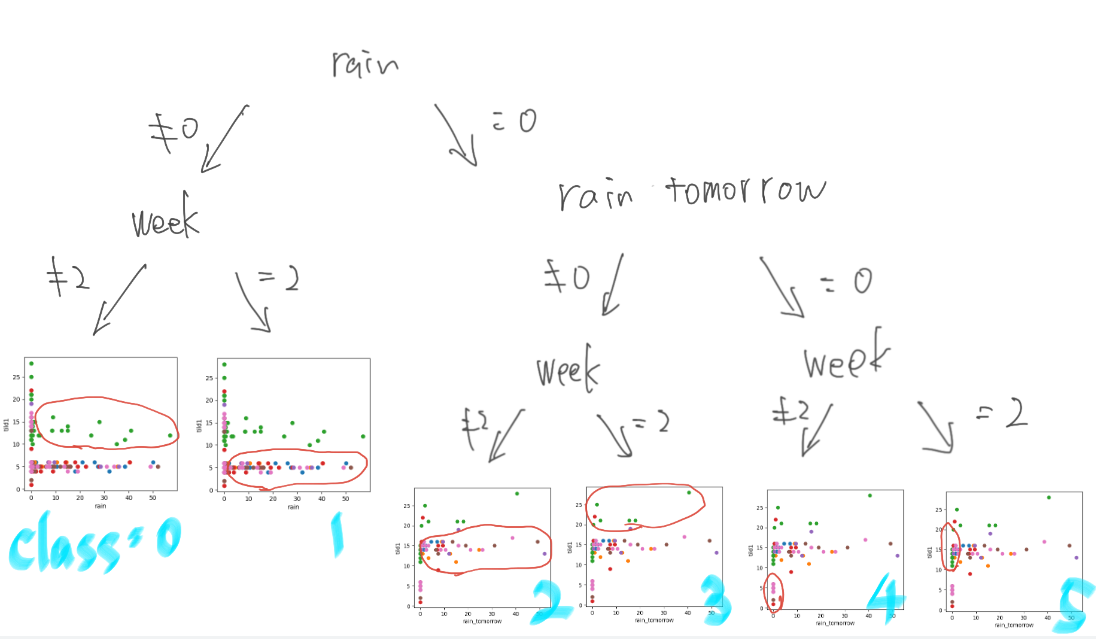

In [ ]:
df_train["tild_class"] = 0
df_train["tild1_pred"] = 0
df_train["tild2_pred"] = 0

for i in range(len(df_train)):
    if df_train["rain"][i] != 0:
        if df_train["week"][i] != 2:
            df_train["tild_class"][i] = 0
            df_train["tild1_pred"][i] = np.average(df_train["tild1"][(df_train["rain"] != 0) & (df_train["week"] != 2)])
            df_train["tild2_pred"][i] = np.average(df_train["tild2"][(df_train["rain"] != 0) & (df_train["week"] != 2)])
        else:
            df_train["tild_class"][i] = 1
            df_train["tild1_pred"][i] = np.average(df_train["tild1"][(df_train["rain"] != 0) & (df_train["week"] == 2)])
            df_train["tild2_pred"][i] = np.average(df_train["tild2"][(df_train["rain"] != 0) & (df_train["week"] == 2)])
    else:
        if df_train["rain_tomorrow"][i] != 0:
            if df_train["week"][i] != 2:
                df_train["tild_class"][i] = 2
                df_train["tild1_pred"][i] = np.average(df_train["tild1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & (df_train["week"] != 2)])
                df_train["tild2_pred"][i] = np.average(df_train["tild2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & (df_train["week"] != 2)])
            else:
                df_train["tild_class"][i] = 3
                df_train["tild1_pred"][i] = np.average(df_train["tild1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & (df_train["week"] == 2)])
                df_train["tild2_pred"][i] = np.average(df_train["tild2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & (df_train["week"] == 2)])
        else:
            if df_train["week"][i] != 2:
                df_train["tild_class"][i] = 4
                df_train["tild1_pred"][i] = np.average(df_train["tild1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & (df_train["week"] != 2)])
                df_train["tild2_pred"][i] = np.average(df_train["tild2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & (df_train["week"] != 2)])
            else:
                df_train["tild_class"][i] = 5
                df_train["tild1_pred"][i] = np.average(df_train["tild1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & (df_train["week"] == 2)])
                df_train["tild2_pred"][i] = np.average(df_train["tild2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & (df_train["week"] == 2)])
                
#plt.scatter(df_train["tild1_pred"], df_train["tild1"])
#plt.scatter(df_train["tild2_pred"], df_train["tild2"])

In [ ]:
df_test["tild_class"] = 0

for i in range(len(df_test)):
    if df_test["rain"][i] != 0:
        if df_test["week"][i] != 2:
            df_test["tild_class"][i] = 0
        else:
            df_test["tild_class"][i] =1
    else:
        if df_test["rain_tomorrow"][i] != 0:
            if df_test["week"][i] != 2:
                df_test["tild_class"][i] = 2
            else:
                df_test["tild_class"][i] = 3
        else:
            if df_test["week"][i] != 2:
                df_test["tild_class"][i] = 4
            else:
                df_test["tild_class"][i] = 5

In [ ]:
#tild1
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["tild1_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["tild1"][(df_train["tild_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["tild1_"+str(taus[j])][(df_test["tild_class"] == i)]=c_array[j]

In [ ]:
#tild2
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["tild2_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["tild2"][(df_train["tild_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["tild2_"+str(taus[j])][(df_test["tild_class"] == i)]=c_array[j]

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.scatter(df_test["date"],df_test["tild1_0.01"])
plt.scatter(df_test["date"],df_test["tild1_0.1"])
plt.scatter(df_test["date"],df_test["tild1_0.5"])
plt.scatter(df_test["date"],df_test["tild1_0.9"])
plt.scatter(df_test["date"],df_test["tild1_0.99"])
plt.ylabel("tild1")
plt.subplot(1,2,2)
plt.scatter(df_test["date"],df_test["tild2_0.01"])
plt.scatter(df_test["date"],df_test["tild2_0.1"])
plt.scatter(df_test["date"],df_test["tild2_0.5"])
plt.scatter(df_test["date"],df_test["tild2_0.9"])
plt.scatter(df_test["date"],df_test["tild2_0.99"])
plt.ylabel("tild2")

# men

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["week"],df_train["men"+str(i+1)])
    plt.xlabel("week")
    plt.ylabel("tild"+str(i+1))

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(6):
    for w in range(7):
        plt.subplot(2,3,i+1)    
        plt.scatter(df_train["rain"][df_train["week"]==w],df_train["men"+str(i+1)][df_train["week"]==w])
        plt.xlabel("rain")
        plt.ylabel("men"+str(i+1))

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(6):
    for w in range(7):
        plt.subplot(2,3,i+1)    
        plt.scatter(df_train["rain_tomorrow"][(df_train["week"]==w) & (df_train["rain"] == 0)],df_train["men"+str(i+1)][(df_train["week"]==w) & (df_train["rain"] == 0)])
        plt.xlabel("rain_tomorrow")
        plt.ylabel("men"+str(i+1))

### tildと同じ考え方

In [ ]:
df_train["men_class"] = 0
df_train["men1_pred"] = 0
df_train["men2_pred"] = 0
df_train["men3_pred"] = 0
df_train["men4_pred"] = 0
df_train["men5_pred"] = 0
df_train["men6_pred"] = 0


for i in range(len(df_train)):
    if df_train["rain"][i] != 0:
        if (df_train["week"][i] == 0) | (df_train["week"][i] == 3) | (df_train["week"][i] == 4):
            df_train["men_class"][i] = 0
            df_train["men1_pred"][i] = np.average(df_train["men1"][(df_train["rain"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
            df_train["men2_pred"][i] = np.average(df_train["men2"][(df_train["rain"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
            df_train["men3_pred"][i] = np.average(df_train["men3"][(df_train["rain"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
            df_train["men4_pred"][i] = np.average(df_train["men4"][(df_train["rain"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
            df_train["men5_pred"][i] = np.average(df_train["men5"][(df_train["rain"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
            df_train["men6_pred"][i] = np.average(df_train["men6"][(df_train["rain"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
        else:
            df_train["men_class"][i] = 1
            df_train["men1_pred"][i] = np.average(df_train["men1"][(df_train["rain"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
            df_train["men2_pred"][i] = np.average(df_train["men2"][(df_train["rain"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
            df_train["men3_pred"][i] = np.average(df_train["men3"][(df_train["rain"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
            df_train["men4_pred"][i] = np.average(df_train["men4"][(df_train["rain"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
            df_train["men5_pred"][i] = np.average(df_train["men5"][(df_train["rain"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
            df_train["men6_pred"][i] = np.average(df_train["men6"][(df_train["rain"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
    else:
        if df_train["rain_tomorrow"][i] != 0:
            if (df_train["week"][i] == 0) | (df_train["week"][i] == 3) | (df_train["week"][i] == 4):
                df_train["men_class"][i] = 2
                df_train["men1_pred"][i] = np.average(df_train["men1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men2_pred"][i] = np.average(df_train["men2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men3_pred"][i] = np.average(df_train["men3"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men4_pred"][i] = np.average(df_train["men4"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men5_pred"][i] = np.average(df_train["men5"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men6_pred"][i] = np.average(df_train["men6"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
            else:
                df_train["men_class"][i] = 3
                df_train["men1_pred"][i] = np.average(df_train["men1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men2_pred"][i] = np.average(df_train["men2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men3_pred"][i] = np.average(df_train["men3"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men4_pred"][i] = np.average(df_train["men4"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men5_pred"][i] = np.average(df_train["men5"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men6_pred"][i] = np.average(df_train["men6"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] != 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
        else:
            if (df_train["week"][i] == 0) | (df_train["week"][i] == 3) | (df_train["week"][i] == 4):
                df_train["men_class"][i] = 4
                df_train["men1_pred"][i] = np.average(df_train["men1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men2_pred"][i] = np.average(df_train["men2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men3_pred"][i] = np.average(df_train["men3"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men4_pred"][i] = np.average(df_train["men4"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men5_pred"][i] = np.average(df_train["men5"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
                df_train["men6_pred"][i] = np.average(df_train["men6"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 0) | (df_train["week"] == 3) | (df_train["week"] == 4))])
            else:
                df_train["men_class"][i] = 5
                df_train["men1_pred"][i] = np.average(df_train["men1"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men2_pred"][i] = np.average(df_train["men2"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men3_pred"][i] = np.average(df_train["men3"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men4_pred"][i] = np.average(df_train["men4"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men5_pred"][i] = np.average(df_train["men5"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                df_train["men6_pred"][i] = np.average(df_train["men6"][(df_train["rain"] == 0) & (df_train["rain_tomorrow"] == 0) & ((df_train["week"] == 1) | (df_train["week"] == 2) | (df_train["week"] == 5) | (df_train["week"] == 6))])
                
#plt.scatter(df_train["men1_pred"], df_train["men1"])
#plt.scatter(df_train["men2_pred"], df_train["men2"])
#plt.scatter(df_train["men3_pred"], df_train["men3"])
#plt.scatter(df_train["men4_pred"], df_train["men4"])
#plt.scatter(df_train["men5_pred"], df_train["men5"])
#plt.scatter(df_train["men6_pred"], df_train["men6"])

In [ ]:
df_test["men_class"] = 0

for i in range(len(df_test)):
    if df_test["rain"][i] != 0:
        if (df_test["week"][i] == 0) | (df_test["week"][i] == 3) | (df_test["week"][i] == 4):
            df_test["men_class"][i] = 0
        else:
            df_test["men_class"][i] =1
    else:
        if df_test["rain_tomorrow"][i] != 0:
            if (df_test["week"][i] == 0) | (df_train["week"][i] == 3) | (df_train["week"][i] == 4):
                df_test["men_class"][i] = 2
            else:
                df_test["men_class"][i] = 3
        else:
            if (df_test["week"][i] == 0) | (df_train["week"][i] == 3) | (df_train["week"][i] == 4):
                df_test["men_class"][i] = 4
            else:
                df_test["men_class"][i] = 5

In [ ]:
#men1
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["men1_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["men1"][(df_train["men_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["men1_"+str(taus[j])][(df_test["men_class"] == i)]=c_array[j]

In [ ]:
#men2
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["men2_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["men2"][(df_train["men_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["men2_"+str(taus[j])][(df_test["men_class"] == i)]=c_array[j]

In [ ]:
#men3
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["men3_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["men3"][(df_train["men_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["men3_"+str(taus[j])][(df_test["men_class"] == i)]=c_array[j]

In [ ]:
#men4
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["men4_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["men4"][(df_train["men_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["men4_"+str(taus[j])][(df_test["men_class"] == i)]=c_array[j]

In [ ]:
#men5
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["men5_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["men5"][(df_train["men_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["men5_"+str(taus[j])][(df_test["men_class"] == i)]=c_array[j]

In [ ]:
#men6
taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
m = len(taus) 

for i in range(m):
    df_test["men6_"+str(taus[i])]=0

for i in range(6):
    y=np.array(df_train["men6"][(df_train["men_class"] == i)])
    
    c_array = np.percentile(y, q=[1, 10, 50, 90, 99])
    
    for j in range(m):
        df_test["men6_"+str(taus[j])][(df_test["men_class"] == i)]=c_array[j]

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(df_test["date"],df_test["men"+str(i+1)+"_0.01"])
    plt.scatter(df_test["date"],df_test["men"+str(i+1)+"_0.1"])
    plt.scatter(df_test["date"],df_test["men"+str(i+1)+"_0.5"])
    plt.scatter(df_test["date"],df_test["men"+str(i+1)+"_0.9"])
    plt.scatter(df_test["date"],df_test["men"+str(i+1)+"_0.99"])
    plt.ylabel("men"+str(i+1))

In [ ]:
df_test

In [ ]:
#df_submission = pd.read_csv("submission.csv")
#column = np.array(df_submission.columns)
#df_test_sub = df_test[column]
#df_test_sub
#df_test_seisu = df_test_sub.round()
#df_test_seisu.to_csv("submission_1.csv", index = False)

# ここまでで Public LB 0.890

# 予測値も使いながらLightGBMで予測(外れ値が特徴的なものを除く、drinkのweek4とか)

In [ ]:
#特徴量
#何週目か
def get_nth_week2(year, month, day, firstweekday=0):
    first_dow = calendar.monthrange(year, month)[0]
    offset = (first_dow - firstweekday) % 7
    return (day + offset - 1) // 7 + 1
week_number = []
for i in range(len(df_train)):
    week_number.append(get_nth_week2(df_train["year"][i], df_train["month"][i], df_train["day"][i]))
df_week_number = pd.DataFrame(week_number)
df_train["week_number"] = df_week_number

#前日雨
df_train["rain_yesterday"] = df_train["rain"].shift()
df_train["rain_yesterday"][0] = np.average(df_train["rain_yesterday"][1:])

#test
#何週目か
week_number = []
for i in range(len(df_test)):
    week_number.append(get_nth_week2(df_test["year"][i], df_test["month"][i], df_test["day"][i]))
df_week_number = pd.DataFrame(week_number)
df_test["week_number"] = df_week_number

#前日雨
df_test["rain_yesterday"] = df_test["rain"].shift()
df_test["rain_yesterday"][0] = df_test["rain"][0] - df_train["rain"][349]

In [ ]:
df_test2 = df_test.copy() #LGBM用
df_test3 = df_test.copy() #XGB用
df_test4 = df_test.copy() #RFR用

In [ ]:
#df_test2_2 = df_test.copy()#lgbmパラメーター変更用

In [ ]:
def lgbm(y_name):
    lgb_train=lgb.Dataset(x_train,y_train[y_name])
    lgb_valid=lgb.Dataset(x_valid,y_valid[y_name])
    
    #LightGBMに与えるパラメータ。回帰なので「regression」それ以外適当です
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'max_depth': 50, #10
        'num_leaves': 200, #50
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'vervose': -1
    }

    #学習
    result_data = {}
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    num_boost_round = 10000,
                    early_stopping_rounds=1000,
                    evals_result = result_data,
#                    verbose_eval=100
                   )
    
    lgb.plot_importance(gbm, max_num_features=5, importance_type='gain')

    plt.figure(figsize=(8, 4))
    pred = gbm.predict(df_x)
        
    #分位点検量線モデル作成    
    cmap = plt.cm.viridis(np.linspace(0., 1., 5))

    X = sm.add_constant(pred)
    model = QuantReg(df_y[y_name], X)

    taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    m = len(taus) 
    N = len(pred)
    Y = np.zeros((m, N))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y[i] = y_hat

    plt.subplot(1,2,1)
    plt.scatter(pred, df_y[y_name], color = "gray")
    for i in range(m):
        plt.plot([min(pred), max(pred)], [min(Y[i]), max(Y[i])], linewidth=2,
                  color=cmap[i], label=r"$\tau=$"+str(taus[i]))
    plt.xlabel("y_cal")
    plt.ylabel("y")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(result_data["training"]["l1"], color = "red", label = "train")
    plt.plot(result_data["valid_1"]["l1"], color = "blue", label = "valid")
    plt.legend()
    
    #テストデータ予測
    pred_test =  gbm.predict(df_x_test)
    X = sm.add_constant(pred_test)

    Y2 = np.zeros((m, len(X)))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y2[i] = y_hat
    
    #結果をテストデータに追加
    for i in range(m):
        df_test2[y_name+"_"+str(taus[i])]=Y2[i]

In [ ]:
#dessert1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert1"]]
df_y = df_train[["dessert1"]]
df_test2["pred_dessert1"] = df_test["dessert1_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("dessert1")

In [ ]:
#dessert2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert2"]]
df_y = df_train[["dessert2"]]
df_test2["pred_dessert2"] = df_test["dessert2_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("dessert2")

In [ ]:
#dessert3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert3"]]
df_y = df_train[["dessert3"]]
df_test2["pred_dessert3"] = df_test["dessert3_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("dessert3")

In [ ]:
#dessert4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert4"]]
df_y = df_train[["dessert4"]]
df_test2["pred_dessert4"] = df_test["dessert4_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert4"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("dessert4")

In [ ]:
#dessert5
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert5"]]
df_y = df_train[["dessert5"]]
df_test2["pred_dessert5"] = df_test["dessert5_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert5"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("dessert5")

In [ ]:
#予測結果
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test2["day"],df_test2["dessert"+str(i+1)+"_0.01"])
    plt.scatter(df_test2["day"],df_test2["dessert"+str(i+1)+"_0.1"])
    plt.scatter(df_test2["day"],df_test2["dessert"+str(i+1)+"_0.5"])
    plt.scatter(df_test2["day"],df_test2["dessert"+str(i+1)+"_0.9"])
    plt.scatter(df_test2["day"],df_test2["dessert"+str(i+1)+"_0.99"])
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))
#大きい値の分布が広くなってしまっている

In [ ]:
#前のデータ
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.01"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.1"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.5"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.9"])
    plt.scatter(df_test["day"],df_test["dessert"+str(i+1)+"_0.99"])
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))
#前のデータは大きい値の分布が狭くなってしまっている

In [ ]:
#前のデータとLGBMのデータの平均を取る
plt.figure(figsize=(15, 16))
for i in range(5):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test2["day"],(df_test2["dessert"+str(i+1)+"_0.01"]+df_test["dessert"+str(i+1)+"_0.01"])/2)
    plt.scatter(df_test2["day"],(df_test2["dessert"+str(i+1)+"_0.1"]+df_test["dessert"+str(i+1)+"_0.1"])/2)
    plt.scatter(df_test2["day"],(df_test2["dessert"+str(i+1)+"_0.5"]+df_test["dessert"+str(i+1)+"_0.5"])/2)
    plt.scatter(df_test2["day"],(df_test2["dessert"+str(i+1)+"_0.9"]+df_test["dessert"+str(i+1)+"_0.9"])/2)
    plt.scatter(df_test2["day"],(df_test2["dessert"+str(i+1)+"_0.99"]+df_test["dessert"+str(i+1)+"_0.99"])/2)
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))

In [ ]:
for i in range(5):
    df_test2["dessert"+str(i+1)+"_0.01"] = (df_test2["dessert"+str(i+1)+"_0.01"]+df_test["dessert"+str(i+1)+"_0.01"])/2
    df_test2["dessert"+str(i+1)+"_0.1"] = (df_test2["dessert"+str(i+1)+"_0.1"]+df_test["dessert"+str(i+1)+"_0.1"])/2
    df_test2["dessert"+str(i+1)+"_0.5"] = (df_test2["dessert"+str(i+1)+"_0.5"]+df_test["dessert"+str(i+1)+"_0.5"])/2
    df_test2["dessert"+str(i+1)+"_0.9"] = (df_test2["dessert"+str(i+1)+"_0.9"]+df_test["dessert"+str(i+1)+"_0.9"])/2
    df_test2["dessert"+str(i+1)+"_0.99"] = (df_test2["dessert"+str(i+1)+"_0.99"]+df_test["dessert"+str(i+1)+"_0.99"])/2


In [ ]:
#hot1
df_x = df_train[["week", "pred_hot1"]]
df_y = df_train[["hot1"]]
df_test2["pred_hot1"] = df_test["hot1_0.5"]
df_x_test = df_test2[["week", "pred_hot1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("hot1")

In [ ]:
#hot2
df_x = df_train[["week", "pred_hot2"]]
df_y = df_train[["hot2"]]
df_test2["pred_hot2"] = df_test["hot2_0.5"]
df_x_test = df_test2[["week", "pred_hot2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("hot2")

In [ ]:
#hot3
df_x = df_train[["week", "pred_hot3"]]
df_y = df_train[["hot3"]]
df_test2["pred_hot3"] = df_test["hot3_0.5"]
df_x_test = df_test2[["week", "pred_hot3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("hot3")

In [ ]:
#snack1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack1"]]
df_y = df_train[["snack1"]]
df_test2["pred_snack1"] = df_test["snack1_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("snack1")

In [ ]:
#snack2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack2"]]
df_y = df_train[["snack2"]]
df_test2["pred_snack2"] = df_test["snack2_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("snack2")

In [ ]:
#snack3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack3"]]
df_y = df_train[["snack3"]]
df_test2["pred_snack3"] = df_test["snack3_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("snack3")

In [ ]:
#bento1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento1"]]
df_y = df_train[["bento1"]]
df_test2["pred_bento1"] = df_test["bento1_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("bento1")

In [ ]:
#bento2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento2"]]
df_y = df_train[["bento2"]]
df_test2["pred_bento2"] = df_test["bento2_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("bento2")

In [ ]:
#bento3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento3"]]
df_y = df_train[["bento3"]]
df_test2["pred_bento3"] = df_test["bento3_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("bento3")

In [ ]:
#bento4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento4"]]
df_y = df_train[["bento4"]]
df_test2["pred_bento4"] = df_test["bento4_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento4"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("bento4")

In [ ]:
#tild1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild1_pred"]]
df_y = df_train[["tild1"]]
df_test2["tild1_pred"] = df_test["tild1_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild1_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("tild1")

In [ ]:
#tild2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild2_pred"]]
df_y = df_train[["tild2"]]
df_test2["tild2_pred"] = df_test["tild2_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild2_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("tild2")

In [ ]:
#men1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men1_pred"]]
df_y = df_train[["men1"]]
df_test2["men1_pred"] = df_test["men1_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men1_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("men1")

In [ ]:
#men2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men2_pred"]]
df_y = df_train[["men2"]]
df_test2["men2_pred"] = df_test["men2_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men2_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("men2")

In [ ]:
#men3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men3_pred"]]
df_y = df_train[["men3"]]
df_test2["men3_pred"] = df_test["men3_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men3_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("men3")

In [ ]:
#men4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men4_pred"]]
df_y = df_train[["men4"]]
df_test2["men4_pred"] = df_test["men4_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men4_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("men4")

In [ ]:
#men5
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men5_pred"]]
df_y = df_train[["men5"]]
df_test2["men5_pred"] = df_test["men5_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men5_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("men5")

In [ ]:
#men6
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men6_pred"]]
df_y = df_train[["men6"]]
df_test2["men6_pred"] = df_test["men6_0.5"]
df_x_test = df_test2[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men6_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
lgbm("men6")

In [ ]:
df_submission = pd.read_csv("submission.csv")
column = np.array(df_submission.columns)
df_test2_sub = df_test2[column]
df_test2_sub
df_test2_seisu = df_test2_sub.round()
#df_test2_seisu.to_csv("submission-lgbm_50.csv", index = False)

# LGBM(max_depth=10)のスコア Public LB 0.869
# LGBM(max_depth=50)のスコア Public LB 0.874

# XGBoost

In [ ]:
def xgb(y_name):
    xgb = XGBR(early_stopping_rounds=10)

    xgb_cv = GridSearchCV(xgb,
                       {'max_depth': [2,4,6],
                        'n_estimators': [50,100,200]}, verbose=1)

    eval_set = [(x_valid, y_valid[y_name])]

    xgb_cv.fit(x_train, y_train[y_name], eval_set=eval_set, verbose=True)
    
    plt.figure(figsize=(8, 4))
    pred = xgb_cv.predict(df_x)

    #分位点検量線モデル作成    
    cmap = plt.cm.viridis(np.linspace(0., 1., 5))

    X = sm.add_constant(pred)
    model = QuantReg(df_y[y_name], X)

    taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    m = len(taus) 
    N = len(pred)
    Y = np.zeros((m, N))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y[i] = y_hat

    plt.subplot(1,2,2)
    plt.scatter(pred, df_y[y_name], color = "gray")
    for i in range(m):
        plt.plot([min(pred), max(pred)], [min(Y[i]), max(Y[i])], linewidth=2,
                  color=cmap[i], label=r"$\tau=$"+str(taus[i]))
    plt.xlabel("y_cal")
    plt.ylabel("y")
    plt.legend()
    
    
    #テストデータ予測
    pred_test =  xgb_cv.predict(df_x_test)
    X = sm.add_constant(pred_test)

    Y2 = np.zeros((m, len(X)))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y2[i] = y_hat
    
    #結果をテストデータに追加
    for i in range(m):
        df_test3[y_name+"_"+str(taus[i])]=Y2[i]

In [ ]:
#dessert1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert1"]]
df_y = df_train[["dessert1"]]
df_test3["pred_dessert1"] = df_test["dessert1_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("dessert1")

In [ ]:
#dessert2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert2"]]
df_y = df_train[["dessert2"]]
df_test3["pred_dessert2"] = df_test["dessert2_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("dessert2")

In [ ]:
#dessert3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert3"]]
df_y = df_train[["dessert3"]]
df_test3["pred_dessert3"] = df_test["dessert3_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("dessert3")

In [ ]:
#dessert4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert4"]]
df_y = df_train[["dessert4"]]
df_test3["pred_dessert4"] = df_test["dessert4_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert4"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("dessert4")

In [ ]:
#dessert5
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert5"]]
df_y = df_train[["dessert5"]]
df_test3["pred_dessert5"] = df_test["dessert5_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert5"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("dessert5")

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test3["day"],df_test3["dessert"+str(i+1)+"_0.01"])
    plt.scatter(df_test3["day"],df_test3["dessert"+str(i+1)+"_0.1"])
    plt.scatter(df_test3["day"],df_test3["dessert"+str(i+1)+"_0.5"])
    plt.scatter(df_test3["day"],df_test3["dessert"+str(i+1)+"_0.9"])
    plt.scatter(df_test3["day"],df_test3["dessert"+str(i+1)+"_0.99"])
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))

In [ ]:
plt.figure(figsize=(15, 16))
for i in range(5):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test3["day"],(df_test3["dessert"+str(i+1)+"_0.01"]+df_test["dessert"+str(i+1)+"_0.01"])/2)
    plt.scatter(df_test3["day"],(df_test3["dessert"+str(i+1)+"_0.1"]+df_test["dessert"+str(i+1)+"_0.1"])/2)
    plt.scatter(df_test3["day"],(df_test3["dessert"+str(i+1)+"_0.5"]+df_test["dessert"+str(i+1)+"_0.5"])/2)
    plt.scatter(df_test3["day"],(df_test3["dessert"+str(i+1)+"_0.9"]+df_test["dessert"+str(i+1)+"_0.9"])/2)
    plt.scatter(df_test3["day"],(df_test3["dessert"+str(i+1)+"_0.99"]+df_test["dessert"+str(i+1)+"_0.99"])/2)
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))

In [ ]:
for i in range(5):
    df_test3["dessert"+str(i+1)+"_0.01"] = (df_test3["dessert"+str(i+1)+"_0.01"]+df_test["dessert"+str(i+1)+"_0.01"])/2
    df_test3["dessert"+str(i+1)+"_0.1"] = (df_test3["dessert"+str(i+1)+"_0.1"]+df_test["dessert"+str(i+1)+"_0.1"])/2
    df_test3["dessert"+str(i+1)+"_0.5"] = (df_test3["dessert"+str(i+1)+"_0.5"]+df_test["dessert"+str(i+1)+"_0.5"])/2
    df_test3["dessert"+str(i+1)+"_0.9"] = (df_test3["dessert"+str(i+1)+"_0.9"]+df_test["dessert"+str(i+1)+"_0.9"])/2
    df_test3["dessert"+str(i+1)+"_0.99"] = (df_test3["dessert"+str(i+1)+"_0.99"]+df_test["dessert"+str(i+1)+"_0.99"])/2

In [ ]:
#hot1
df_x = df_train[["week", "pred_hot1"]]
df_y = df_train[["hot1"]]
df_test3["pred_hot1"] = df_test["hot1_0.5"]
df_x_test = df_test3[["week", "pred_hot1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("hot1")

In [ ]:
#hot2
df_x = df_train[["week", "pred_hot2"]]
df_y = df_train[["hot2"]]
df_test3["pred_hot2"] = df_test["hot2_0.5"]
df_x_test = df_test3[["week", "pred_hot2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("hot2")

In [ ]:
#hot3
df_x = df_train[["week", "pred_hot3"]]
df_y = df_train[["hot3"]]
df_test3["pred_hot3"] = df_test["hot3_0.5"]
df_x_test = df_test3[["week", "pred_hot3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("hot3")

In [ ]:
#snack1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack1"]]
df_y = df_train[["snack1"]]
df_test3["pred_snack1"] = df_test["snack1_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("snack1")

In [ ]:
#snack2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack2"]]
df_y = df_train[["snack2"]]
df_test3["pred_snack2"] = df_test["snack2_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("snack2")

In [ ]:
#snack3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack3"]]
df_y = df_train[["snack3"]]
df_test3["pred_snack3"] = df_test["snack3_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("snack3")

In [ ]:
#bento1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento1"]]
df_y = df_train[["bento1"]]
df_test3["pred_bento1"] = df_test["bento1_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("bento1")

In [ ]:
#bento2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento2"]]
df_y = df_train[["bento2"]]
df_test3["pred_bento2"] = df_test["bento2_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("bento2")

In [ ]:
#bento3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento3"]]
df_y = df_train[["bento3"]]
df_test3["pred_bento3"] = df_test["bento3_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("bento3")

In [ ]:
#bento4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento4"]]
df_y = df_train[["bento4"]]
df_test3["pred_bento4"] = df_test["bento4_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento4"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("bento4")

In [ ]:
#tild1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild1_pred"]]
df_y = df_train[["tild1"]]
df_test3["tild1_pred"] = df_test["tild1_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild1_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("tild1")

In [ ]:
#tild2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild2_pred"]]
df_y = df_train[["tild2"]]
df_test3["tild2_pred"] = df_test["tild2_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild2_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("tild2")

In [ ]:
#men1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men1_pred"]]
df_y = df_train[["men1"]]
df_test3["men1_pred"] = df_test["men1_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men1_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("men1")

In [ ]:
#men2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men2_pred"]]
df_y = df_train[["men2"]]
df_test3["men2_pred"] = df_test["men2_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men2_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("men2")

In [ ]:
#men3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men3_pred"]]
df_y = df_train[["men3"]]
df_test3["men3_pred"] = df_test["men3_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men3_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("men3")

In [ ]:
#men4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men4_pred"]]
df_y = df_train[["men4"]]
df_test3["men4_pred"] = df_test["men4_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men4_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("men4")

In [ ]:
#men5
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men5_pred"]]
df_y = df_train[["men5"]]
df_test3["men5_pred"] = df_test["men5_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men5_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("men5")

In [ ]:
#men6
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men6_pred"]]
df_y = df_train[["men6"]]
df_test3["men6_pred"] = df_test["men6_0.5"]
df_x_test = df_test3[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men6_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
xgb("men6")

In [ ]:
#df_submission = pd.read_csv("submission.csv")
#column = np.array(df_submission.columns)
df_test3_sub = df_test3[column]
df_test3_sub
df_test3_seisu = df_test3_sub.round()
#df_test3_seisu.to_csv("final_submission-xgb.csv", index = False)

# XGBのスコア Public LB 0.877

# Randam Forest

In [ ]:
def rfr(y_name):
    search_params = {
        'n_estimators'      : [50, 200, 500],
        'random_state'      : [0],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth'         : [4, 5, 6, 7, 8], 
    }

    rfr_cv = GridSearchCV(
        RFR(),
        search_params,
        cv = 5,
        n_jobs = -1,
        verbose=True
    )

    rfr_cv.fit(df_x, df_y[y_name])
    
    best_rfc=rfr_cv.best_estimator_

    plt.figure(figsize=(8, 4))
    pred = best_rfc.predict(df_x)

    #分位点検量線モデル作成    
    cmap = plt.cm.viridis(np.linspace(0., 1., 5))

    X = sm.add_constant(pred)
    model = QuantReg(df_y[y_name], X)

    taus = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    m = len(taus) 
    N = len(pred)
    Y = np.zeros((m, N))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y[i] = y_hat

    plt.subplot(1,2,2)
    plt.scatter(pred, df_y[y_name], color = "gray")
    for i in range(m):
        plt.plot([min(pred), max(pred)], [min(Y[i]), max(Y[i])], linewidth=2,
                  color=cmap[i], label=r"$\tau=$"+str(taus[i]))
    plt.xlabel("y_cal")
    plt.ylabel("y")
    plt.legend()
    
    
    #テストデータ予測
    pred_test =  best_rfc.predict(df_x_test)
    X = sm.add_constant(pred_test)

    Y2 = np.zeros((m, len(X)))

    for i in range(m):    
        results = model.fit(q=taus[i])
        y_hat = X @ results.params
        Y2[i] = y_hat
    
    #結果をテストデータに追加
    for i in range(m):
        df_test4[y_name+"_"+str(taus[i])]=Y2[i]

In [ ]:
#dessert1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert1"]]
df_y = df_train[["dessert1"]]
df_test4["pred_dessert1"] = df_test["dessert1_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("dessert1")

In [ ]:
#dessert2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert2"]]
df_y = df_train[["dessert2"]]
df_test4["pred_dessert2"] = df_test["dessert2_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("dessert2")

In [ ]:
#dessert3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert3"]]
df_y = df_train[["dessert3"]]
df_test4["pred_dessert3"] = df_test["dessert3_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("dessert3")

In [ ]:
#dessert4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert4"]]
df_y = df_train[["dessert4"]]
df_test4["pred_dessert4"] = df_test["dessert4_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert4"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("dessert4")

In [ ]:
#dessert5
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert5"]]
df_y = df_train[["dessert5"]]
df_test4["pred_dessert5"] = df_test["dessert5_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_dessert5"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("dessert5")

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2,3,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test4["day"],df_test4["dessert"+str(i+1)+"_0.01"])
    plt.scatter(df_test4["day"],df_test4["dessert"+str(i+1)+"_0.1"])
    plt.scatter(df_test4["day"],df_test4["dessert"+str(i+1)+"_0.5"])
    plt.scatter(df_test4["day"],df_test4["dessert"+str(i+1)+"_0.9"])
    plt.scatter(df_test4["day"],df_test4["dessert"+str(i+1)+"_0.99"])
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))

In [ ]:
plt.figure(figsize=(15, 16))
for i in range(5):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_train["day"],df_train["dessert"+str(i+1)])
    plt.scatter(df_test4["day"],(df_test4["dessert"+str(i+1)+"_0.01"]+df_test["dessert"+str(i+1)+"_0.01"])/2)
    plt.scatter(df_test4["day"],(df_test4["dessert"+str(i+1)+"_0.1"]+df_test["dessert"+str(i+1)+"_0.1"])/2)
    plt.scatter(df_test4["day"],(df_test4["dessert"+str(i+1)+"_0.5"]+df_test["dessert"+str(i+1)+"_0.5"])/2)
    plt.scatter(df_test4["day"],(df_test4["dessert"+str(i+1)+"_0.9"]+df_test["dessert"+str(i+1)+"_0.9"])/2)
    plt.scatter(df_test4["day"],(df_test4["dessert"+str(i+1)+"_0.99"]+df_test["dessert"+str(i+1)+"_0.99"])/2)
    plt.xlabel("day")
    plt.ylabel("dessert"+str(i+1))

In [ ]:
for i in range(5):
    df_test4["dessert"+str(i+1)+"_0.01"] = (df_test4["dessert"+str(i+1)+"_0.01"]+df_test["dessert"+str(i+1)+"_0.01"])/2
    df_test4["dessert"+str(i+1)+"_0.1"] = (df_test4["dessert"+str(i+1)+"_0.1"]+df_test["dessert"+str(i+1)+"_0.1"])/2
    df_test4["dessert"+str(i+1)+"_0.5"] = (df_test4["dessert"+str(i+1)+"_0.5"]+df_test["dessert"+str(i+1)+"_0.5"])/2
    df_test4["dessert"+str(i+1)+"_0.9"] = (df_test4["dessert"+str(i+1)+"_0.9"]+df_test["dessert"+str(i+1)+"_0.9"])/2
    df_test4["dessert"+str(i+1)+"_0.99"] = (df_test4["dessert"+str(i+1)+"_0.99"]+df_test["dessert"+str(i+1)+"_0.99"])/2

In [ ]:
#snack1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack1"]]
df_y = df_train[["snack1"]]
df_test4["pred_snack1"] = df_test["snack1_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("snack1")

In [ ]:
#snack2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack2"]]
df_y = df_train[["snack2"]]
df_test4["pred_snack2"] = df_test["snack2_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("snack2")

In [ ]:
#snack3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack3"]]
df_y = df_train[["snack3"]]
df_test4["pred_snack3"] = df_test["snack3_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_snack3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("snack3")

In [ ]:
#bento1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento1"]]
df_y = df_train[["bento1"]]
df_test4["pred_bento1"] = df_test["bento1_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento1"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("bento1")

In [ ]:
#bento2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento2"]]
df_y = df_train[["bento2"]]
df_test4["pred_bento2"] = df_test["bento2_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento2"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("bento2")

In [ ]:
#bento3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento3"]]
df_y = df_train[["bento3"]]
df_test4["pred_bento3"] = df_test["bento3_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento3"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("bento3")

In [ ]:
#bento4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento4"]]
df_y = df_train[["bento4"]]
df_test4["pred_bento4"] = df_test["bento4_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "pred_bento4"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("bento4")

In [ ]:
#tild1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild1_pred"]]
df_y = df_train[["tild1"]]
df_test4["tild1_pred"] = df_test["tild1_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild1_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("tild1")

In [ ]:
#tild2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild2_pred"]]
df_y = df_train[["tild2"]]
df_test4["tild2_pred"] = df_test["tild2_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "tild2_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("tild2")

In [ ]:
#men1
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men1_pred"]]
df_y = df_train[["men1"]]
df_test4["men1_pred"] = df_test["men1_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men1_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("men1")

In [ ]:
#men2
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men2_pred"]]
df_y = df_train[["men2"]]
df_test4["men2_pred"] = df_test["men2_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men2_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("men2")

In [ ]:
#men3
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men3_pred"]]
df_y = df_train[["men3"]]
df_test4["men3_pred"] = df_test["men3_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men3_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("men3")

In [ ]:
#men4
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men4_pred"]]
df_y = df_train[["men4"]]
df_test4["men4_pred"] = df_test["men4_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men4_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("men4")

In [ ]:
#men5
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men5_pred"]]
df_y = df_train[["men5"]]
df_test4["men5_pred"] = df_test["men5_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men5_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("men5")

In [ ]:
#men6
df_x = df_train[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men6_pred"]]
df_y = df_train[["men6"]]
df_test4["men6_pred"] = df_test["men6_0.5"]
df_x_test = df_test4[["highest", "lowest", "rain", "month", "day", "week", "week_number", "rain_yesterday", "rain_tomorrow", "men6_pred"]]
x_train, x_valid, y_train, y_valid= train_test_split(df_x, df_y, test_size=0.3, random_state=0)
rfr("men6")

In [ ]:
#df_submission = pd.read_csv("submission.csv")
#column = np.array(df_submission.columns)
df_test4_sub = df_test4[column]
df_test4_sub
df_test4_seisu = df_test4_sub.round()
#df_test4_seisu.to_csv("final_submission-rfr.csv", index = False)

# RFRのスコア Public LB 0.887

# Averaging

In [ ]:
df_sub_ave = (df_test2_sub+df_test3_sub+df_test4_sub)/3
df_sub_ave

In [ ]:
#df_submission = pd.read_csv("submission.csv")
#column = np.array(df_submission.columns)
df_sub_ave_seisu = df_sub_ave.round()
df_sub_ave_seisu.to_csv("final_submission-ave.csv", index = False)

# 最終スコア Public LB 0.864